# Predicting House Sale Prices in Ames, Iowa
Jack Kolberg-Edelbrock, MS
## Executive Summary

In this project, I worked with the Ames, Iowa housing dataset with the goal of predicting home prices based upon the many data columns within the dataset. Using a combination of data cleaning and feature engineering, I produced a dataset with information usable by a machine learning model. Afterwards, I examined individual columns in the dataset to determine which columns would be non-collinear and a good fit for use in the machine learning model. Finally, I performed K nearest neighbor and linear regression fits on multiple subsets of the chosen data to obtain a linear regression RMSE of \\$25,032, or 14% on an average sale price of \\$175,778

## Introduction

The Ames, Iowa housing dataset represents a classic exercise in machine learning. This extensive dataset contains information ranging from the unquestionably important square footage of a house down to the value of the dilapidated shed that the owner forgot was in their backyard. The multitude of datapoints provided in the dataset challenges learners to perform extensive data cleaning as well as think critically about the interplay of seemingly different pieces of data before including them in a machine learning model.

In this project, I performed used feature engineering and machine learning to analyze the Ames, Iowa housing dataset.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

data = pd.read_csv('./Data/AmesHousing.tsv', delimiter = '\t')
data_copy = data.copy()

## Data Transformation Dictionaries
### Transform Dictionary

This dictionary contains information for remapping values in most columns of the input data. There are two purposes for this transformation:
1. Transform "falsely categorical" categorical columns into numeric columns:
    * `Heating QC = ['Ex', 'Gd', 'TA', 'Fa', 'Po', np.nan]`
    * Can be interpreted numerically as 
    * `Heating QC = [2, 1, 0, -1, -2, -2]`
2. Make abbreviated values in the columns more meaningful to a human:
    * `'MS SubClass': 20` --> `'MS SubClass': '1StoryNew'`

In [2]:
transform_dictionary = {'MS SubClass':     { 20:'1StoryNew',           30:'1StoryOld',          40:'1StoryFinishedAttic',
                                             45:'1.5StoryUnfinished',  50:'1.5StoryFinished',   60:'2StoryNew', 
                                             70:'2StoryOld',           75:'2.5Story',           80:'SplitLevel',
                                             85:'SplitFoyer',          90:'Duplex',            120:'1StoryPlannedNew', 
                                            150:'1.5StoryPlanned',    160:'2StoryPlannedNew',  180:'MultiLevelPlanned', 
                                            190:'2FamilyConversion'},
                        'MS Zoning':       { 'C':'Commercial',              'FV':'FloatingVillage',        'I':'Industrial',
                                            'RH':'HighDensityResidential',  'RL':'LowDensityResidential', 'RP':'LowDensityResidential_Park',
                                            'RM':'MediumDensityResidential'},
                        'Street':          {'Grvl':'Gravel', 'Pave':'Paved'},
                        'Lot Shape':       {'Reg':'Regular', 'IR1':'SlightlyIrregular', 'IR2':'ModeratelyIrregular', 'IR3':'Irregular'},
                        'Alley':           {'Grvl':'Gravel', 'Pave':'Pave', np.nan:'None'},
                        'Utilities':       {'AllPub':'All', 'NoSewr':'NoSewer', 'NoSeWa':'NoWater/NoSewer', 'ELO':'ElectricOnly'},
                        'Lot Config':      {'Inside':'Inner', 'Corner':'Corner', 'CulDSac':'CulDSac','FR2':'2SideFrontage',
                                            'FR3':'3SideFrontage'},
                        'Land Slope':      {'Gtl':'Gentle', 'Mod':'Moderate', 'Sev':'Severe'},
                        'Neighborhood':    {'Blmngtn':'Bloomington Heights',  'Blueste':'Bluestem',            'BrDale':'Briardale',
                                            'BrkSide':'Brookside',            'ClearCr':'Clear Creek',         'CollgCr':'College Creek',
                                            'Crawfor':'Crawford',             'Edwards':'Edwards',             'Gilbert':'Gilbert',
                                            'Greens':'Greens',                'GrnHill':'Green Hill',          'IDOTRR':'Iowa DOT and Railroad',
                                            'Landmrk':'Landmark',             'MeadowV':'Meadow Village',      'Mitchel':'Mitchell',
                                            'NAmes':'North Ames',             'NPkVill':'Northpark Villa',     'NWAmes':'Northwest Ames',
                                            'NoRidge':'Northridge',           'NridgHt':'Northridge Heights',  'OldTown':'Old Town',
                                            'SWISU':'Southwest ISU',          'Sawyer':'Sawyer',               'SawyerW':'Sawyer West',
                                            'Somerst':'Somerset',             'StoneBr':'Stone Brook',         'Timber':'Timberland',
                                            'Veenker':'Veenker'},
                        'Condition 1':     {'Artery':'OnArtery',      'Feedr':'OnFeeder',           'Norm':'NoSpecialCond',
                                            'RRNn':'NearRailroad',    'RRAn':'AdjacentToRailroad',  'PosN':'NearPark', 
                                            'PosA':'AdjacentToPark',  'RRNe':'NearRailroad',        'RRAe':'AdjacentToRailroad'},
                        'Condition 2':     {'Artery':'OnArtery',      'Feedr':'OnFeeder',           'Norm':'NoSpecialCond',
                                            'RRNn':'NearRailroad',    'RRAn':'AdjacentToRailroad',  'PosN':'NearPark', 
                                            'PosA':'AdjacentToPark',  'RRNe':'NearRailroad',        'RRAe':'AdjacentToRailroad'},
                        'Bldg Type':       {'1Fam':'SingleFamily',    '2FmCon':'2FamilyConversion', 'Duplx':'Duplex',
                                            'TwnhsE':'TownhouseEnd',  'TwnhsI':'TownhouseInner'},
                        'Exter Qual':      {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2},
                        'Roof Style':      {'Flat':'Flat', 'Gable':'Gable', 'Gambrel':'Barn', 'Hip':'Hip', 'Mansard':'Mansard',
                                            'Shed':'Shed'},
                        'Roof Matl':       {'ClyTile':'ClayOrTile',   'CompShingle':'StandardShingle', 'Membran':'Membrane', 
                                            'Metal':'Metal',          'Roll':'Roll',                   'Tar&Grv':'TarGravel', 
                                            'WdShake':'WoodShake',    'WdShngl':'WoodShingle'},
                        'Exterior 1st':    {'AsbShng':'AsbestosShingles', 'AsphShn':'AsphaltShingles',   'BrkCommon':'CommonBrick', 
                                            'BrkFace':'FaceBrick',        'CBlock':'CinderBlock',        'CementBd':'CementBoard',
                                            'HdBoard':'HardBoard',        'ImStucc':'ImitationStucco',   'MetalSd':'MetalSiding',
                                            'Other':'Other',              'Plywood':'Plywood',           'PreCast':'PreCast',
                                            'Stone':'Stone',              'VinylSd':'Vinyl',             'Wd Sdng':'WoodSiding',
                                            'WdShing':'WoodShingles'},
                        'Exterior 2nd':    {'AsbShng':'AsbestosShingles',   'AsphShn':'AsphaltShingles',  'BrkCommon':'CommonBrick', 
                                            'BrkFace':'FaceBrick',          'CBlock':'CinderBlock',       'CementBd':'CementBoard',
                                            'HdBoard':'HardBoard',          'ImStucc':'ImitationStucco',  'MetalSd':'MetalSiding',
                                            'Other':'Other',                'Plywood':'Plywood',          'PreCast':'PreCast',
                                            'Stone':'Stone',                'VinylSd':'Vinyl',            'Wd Sdng':'WoodSiding',
                                            'WdShing':'WoodShingles'},
                        'Foundation':      {'BrkTil':'BrickTile',   'CBlock':'CinderBlock',   'PConc':'PouredConcrete', 
                                            'Slab':'ConcreteSlab',  'Stone':'Stone',          'Wood':'Wood'},
                        'Bsmt Cond':       {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2, np.nan:-2},
                        'Bsmt Exposure':   {'Gd':'Good', 'Av':'Average', 'Mn':'Minimal', 'No':'None', 'NA':'NoBasement'},
                        'BsmtFin Type 1':  {'GLQ':'GoodLivingQuarters',  'ALQ':'AverageLivingQuarters',  'BLQ':'PoorLivingQuarters',
                                            'Rec':'RecRoom',             'LwQ':'BadLivingQuarters',      'Unf':'Unfinished', 
                                            np.nan:'None'},
                        'BsmtFin Type 2':  {'GLQ':'GoodLivingQuarters',  'ALQ':'AverageLivingQuarters',  'BLQ':'PoorLivingQuarters',
                                            'Rec':'RecRoom',             'LwQ':'BadLivingQuarters',      'Unf':'Unfinished', 
                                            np.nan:'None'},
                        'Heating':         {'Floor':'FloorFurnace',      'GasA':'ForcedAir',          'GasW':'Radiant', 
                                            'Grav':'GravityFurnace',     'OthW':'NonGasWaterHeating', 'Wall':'WallFurnace'},
                        'Heating QC':      {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2},
                        'Central Air':     {'N':0, 'Y':1},
                        'Electrical':      {'SBrkr':'StandardBreakers', 'FuseA':'60ARomex', 'FuseF':'60AMixed', 
                                            'FuseP':'60AKnobTube',      'Mix':'Mixed'},
                        'Kitchen Qual':    {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2},
                        'Functional':      {'Typ':'Typical',          'Min1':'MinimalProblems', 'Min2':'MinimalProblems',
                                            'Mod':'ModerateProblems', 'Maj1':'MajorProblems',   'Maj2':'MajorProblems', 
                                            'Sev':'SevereProblems',   'Sal':'SalvageOnly'},
                        'Fireplace Qu':    {'Ex':'ExceptionalMasonry',    'Gd':'Masonry',    'TA':'Prefab',    'Fa':'Prefab', 
                                            'Po':'Stove',                  np.nan:'None'},
                        'Garage Type':     {'2Types':'TwoTypes', 'Attchd':'Attached', 'Bsment':'Basement', 
                                            'BuiltIn':'BuiltIn', 'CarPort':'CarPort', 'Detchd':'Detached', 
                                            np.nan:'None'},
                        'Garage Qual':     {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2, np.nan:-2},
                        'Paved Drive':     {'Y':'Paved', 'P':'Mixed', 'N':'Unpaved'},
                        'Pool QC':         {'Ex':2, 'Gd':1, 'TA':0, 'Fa':-1, 'Po':-2, np.nan:-2},
                        'Fence':           {'GdPrv':'GoodPrivacy',   'MnPrv':'MinimalPrivacy',   'GdWo':'GoodWood', 
                                            'MnWw':'MinimumWire',    np.nan:'None'},
                        'Sale Condition':  {'Normal':'Normal',    'Abnorml':'Foreclosure', 'AdjLand':'AdjoiningSale', 
                                            'Alloca':'Allocation', 'Family':'Family',
                                            'Partial':'Partial'},
                        'Mo Sold':         {1:'Jan', 2:'Feb', 3:'Mar',  4:'Apr',  5:'May', 6:'Jun', 7:'Jul',
                                            8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}}

### Neighborhood Geographic Grouping

This dictionary contains the information needed to group individual neighborhoods (previously transformed by the dictionary above) into the more general 'geographic' groupings as defined in the main body of the project.

In [3]:
neighborhood_grouping =  {'Bloomington Heights':'Far North',  'Bluestem':'Southwest',           'Briardale':'Near North',
                          'Brookside':'Downtown',             'Clear Creek':'Near West',        'College Creek':'Far West',
                          'Crawford':'Southwest ISU',         'Edwards':'Near West',            'Gilbert':'Far North',
                          'Greens':'Northwest',               'Green Hill':'Far Southwest',     'Iowa DOT and Railroad':'Downtown',
                          'Landmark':'Far West',              'Meadow Village':'South',         'Mitchell':'South',
                          'North Ames':'Near North',          'Northpark Villa':'Near North',   'Northwest Ames':'Near North', 
                          'Northridge':'Northwest',           'Northridge Heights':'Northwest', 'Old Town':'Downtown',
                          'Southwest ISU':'Southwest',        'Sawyer':'Near West',             'Sawyer West':'Far West',
                          'Somerset':'Northwest',             'Stone Brook':'Far North',        'Timberland':'Far Southwest',
                          'Veenker':'Near West'}

---
## Core Functions

### transform_features
*This function performs the majority of the data cleaning required in this project.* 

**Parameters**
* *df_in* = the DataFrame containing the data that will be transformed/cleaned
* *transforms* = a dictionary that is used to remap the data contained in df_in

**Returns**
* *df* = the transformed/cleaned DataFrame

**Process description**
1. Remap the DataFrame with the values stored in the transforms dictonary
2. Preprocess numeric columns:
    * Fill np.nan values
    * Cast all values as floats
3. Preprocess categorical columns:
    * Identify prefixes for categorical columns
    * Cast predummied and future dummy columns appropriately
    * Generate non-engineered dummy columns
4. Perform feature engineering
    * Altered temporal columns
    * Summary columns for certain sets of numeric columns
    * Combined dummy columns for sets of similar categorical columns
5. Clean-up
    * Append dummies to DataFrame
    * Remove consumed, unimportant, and unusable columns from DataFrame

In [4]:
def transform_features(df_in, transforms):
    df = df_in.copy()
    
    # ===========================
    # Remap original values in df
    # ---------------------------
    for col in transforms.keys():
        df[col] = df[col].map(transforms[col])
    message = '===== Successfully remapped the dataframe ====='
    print(f'\n{"=" * len(message)}\n{message}\n{"=" * len(message)}\n{list(transforms.keys())}\n')
    
    # =============================
    # Pre-process numerical columns
    # -----------------------------
    # List numeric columns according to na fill value
    numeric_cols_fill_mean = ['Lot Frontage', 'Lot Area', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Exter Qual',
                              'Bsmt Cond', 'Heating QC', '1st Flr SF', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
                              'Kitchen Qual', 'Garage Yr Blt', 'Garage Qual','Pool QC', 'SalePrice']
    numeric_cols_fill_zero = ['Total Bsmt SF', '2nd Flr SF', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplaces',
                              'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 
                              'Screen Porch', 'Misc Val',]
    already_dummy_cols = ['Central Air']
    
    # Cast numeric columns as floats
    df[numeric_cols_fill_mean] = df[numeric_cols_fill_mean].astype(float)
    df[numeric_cols_fill_zero] = df[numeric_cols_fill_zero].astype(float)
    df[already_dummy_cols] = df[already_dummy_cols].astype(int)
    
    # Fill missing values
    for col in numeric_cols_fill_mean:
        df[col] = df[col].fillna(df[col].mean())
    for col in numeric_cols_fill_zero:
        df[col] = df[col].fillna(0)
    
    # ===============================
    # Pre-process categorical columns
    # -------------------------------
    nl_categorical_cols = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Utilities', 'Lot Config',
                           'Land Slope', 'Bldg Type', 'Roof Style', 'Roof Matl', 'Foundation', 'Bsmt Exposure', 
                           'Heating', 'Electrical', 'Functional', 'Garage Type', 'Paved Drive', 
                           'Fence', 'Mo Sold', 'Yr Sold', 'Sale Condition', 'Fireplace Qu', 'Neighborhood']
    nl_categorical_prefixes = ['SubClass', 'Zoning', 'Street', 'Alley', 'LotShape', 'Utilities', 'Lot', 
                               'LotSlope', 'Bldg', 'Roof', 'RoofMatl', 'Foundation', 'BsmtExposure',
                               'Heating', 'Electric', 'Condition', 'Garage', 'Driveway', 'Fence', 'MonthSold', 
                               'YearSold', 'Sale', 'Fireplace', 'Nhood']

    special_categorical_cols = ['Condition 1', 'Condition 2', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Exterior 1st', 'Exterior 2nd']
    special_categorical_prefixes = ['Location', 'Location', 'BasementFinish', 'BasementFinish', 'Exterior', 'Exterior']    
    
    # Cast categorical columns as objects
    df[nl_categorical_cols] = df[nl_categorical_cols].astype(object)   
    df[special_categorical_cols] = df[special_categorical_cols].astype(object)
    # Cast pre-dummied columns as ints
    df[already_dummy_cols] = df[already_dummy_cols].astype(int)

    # Create normal dummies
    nl_dummies = pd.DataFrame()
    for i in range(len(nl_categorical_cols)):
        dummy = pd.get_dummies(df[nl_categorical_cols[i]], nl_categorical_prefixes[i])
        nl_dummies = pd.concat([nl_dummies, dummy], axis = 1)
    
    # ===================
    # Feature Engineering
    # -------------------
    # Convert feature built years to feature ages (2021 = ref year)
    df['Years Since Remodel'] = 2021 - df['Year Remod/Add']
    df['Garage Age'] = 2021 - df['Garage Yr Blt']

    # Create column to represent historical homes (pre 1930)
    df['Historical'] = (df['Year Built'] < 1930).astype(int)
    
    # Create summative quantitative columns
    df['Total SF'] = df['Total Bsmt SF'] + df['1st Flr SF'] + df['2nd Flr SF']
    df['Porch SF'] = df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch']
    df['Bathrooms'] = df['Bsmt Full Bath'] + df['Full Bath'] + 0.5 * (df['Bsmt Half Bath'] + df['Half Bath'])
   
    # Create summative dummies (ie, if a row has two of the same conditions, the value in the dummy can be 2)
    location_dummies = pd.get_dummies(df['Condition 1'], 'Location') + pd.get_dummies(df['Condition 2'], 'Location')
    bsmtfin_dummies = pd.get_dummies(df['BsmtFin Type 1'], 'BsmtFin') + pd.get_dummies(df['BsmtFin Type 2'], 'BsmtFin')
    exterior_dummies = pd.get_dummies(df['Exterior 1st'], 'Exterior') + pd.get_dummies(df['Exterior 2nd'], 'Exterior')
    
    # -------------------------------------------------------------------------------------------
    # Function to drop columns
    def drop_columns(df, cols, message):
        df = df.drop(cols, axis = 1)
        message = f'===== Dropped {len(cols)} {message} ====='
        print(f'{"="*len(message)}\n{message}\n{"="*len(message)}\n{cols} \n')
        return df
    # -------------------------------------------------------------------------------------------
    
    # ================
    # Clean up dataset
    # ----------------
    # Append dummies back to df
    df = pd.concat([df, nl_dummies, location_dummies, bsmtfin_dummies, exterior_dummies], axis = 1)
    
    # Drop consumed columns
    consumed_cols = ['Year Remod/Add', 'Garage Yr Blt', 'Year Built']
    df = drop_columns(df, consumed_cols, 'columns after converting them to nominal data.')
    
    # Drop combined columns
    combined_cols = ['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Open Porch SF', 
                        'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Bsmt Full Bath', 
                        'Full Bath', 'Bsmt Half Bath', 'Half Bath']
    df = drop_columns(df, combined_cols, 'columns after combining them into summative quantitative columns')
    
    # Drop categorical columns
    df = drop_columns(df, nl_categorical_cols, 'columns after converting them to dummies.')
    df = drop_columns(df, special_categorical_cols, 'columns after converting them to dummies and combining them.')

    # Drop uncategorizable and unquantifiable columns
    uncat_unquant_cols = ['Order', 'PID']
    df = drop_columns(df, uncat_unquant_cols, 'columns that contained uncategorizable and unquantifiable data.')
    
    # Drop duplicated columns
    duplicate_cols =     ['Exter Cond', 'Garage Finish', 'Garage Cond', 'Bsmt Unf SF',
                          'Bsmt Qual', 'Garage Cars', 'BsmtFin SF 1', 'BsmtFin SF 2',
                          'House Style', 'Gr Liv Area', 'TotRms AbvGrd', 'Land Contour']
    df = drop_columns(df, duplicate_cols, 'columns which contained data represented in other columns.')
    
    # Drop unimportant columns
    unimportant_cols =   ['Mas Vnr Type', 'Mas Vnr Area','Sale Type', 'Misc Feature', 'Low Qual Fin SF']
    df = drop_columns(df, unimportant_cols, 'columns which did not contain useful information.')
    
    # Drop unused categorical columns
    unused_categorical = ['Exterior_Other', 'Exterior_WoodShingles', 'Condition_SalvageOnly']
    df = drop_columns(df, unused_categorical, 'categorical columns which contained no information.')
    
    message = f'===== After cleaning there are {data_copy.shape[1]} data columns ====='
    print(f'{"=" * len(message)}\n{message}\n{"=" * len(message)}')
    
    return df

### select_features
*Selects fit features on the basis of a correlation cutoff.*


**Parameters**
* *df* = the dataframe from which to select features, this should contain correlations between variables
* *positive_cutoff* = the correlation cutoff below which positive correlations are considered insignificant
* *negative_cutoff* = the correlation cutoff above which negative correlations are considered insignificant
* *target_col* = the name of the column that we are interested in correlations against (ie: SalePrice)
* *exclude* = columns that we are not interested in viewing the correlations of

**Returns**
* A list of column titles that have a positive correlation greater than positive_cutoff
* A list of column titles that have a negative correlation less than the negative_cutoff

In [5]:
def select_features(df, positive_cutoff, negative_cutoff, target_col, exclude = []):
    strong_pos = df.index[df.loc[:, target_col] > positive_cutoff] 
    strong_neg = df.index[df.loc[:, target_col] < negative_cutoff]
    
    # Drop excluded features
    for item in exclude:
        if (exclude in list(strong_pos)):
            strong_pos = strong_pos.drop(exclude)
        if (exclude in list(strong_neg)):
            strong_neg = strong_neg.drop(exclude)
    return strong_pos.tolist(), strong_neg.tolist()

### train_and_test_kneighbors
*This function automates fitting and testing of a k_nearest_neighbors model.*

**Parameters**
* *train_df* = the dataframe used for training the model
* *test_df* = the dataframe used to validate the model
* *fit_params* = a list of the names of columns to be used to fit the model
* *target_param* = the parameter the model attempts to predict
* *num_neighbors* = the number of neighbors to use in the model
* *k* = the number of subsets to split the data into for KFold validation

**Returns**
* *rmse* = the average root mean squared error amongst the KFold subsets
* *stdev* = the standard deviation of the rmse values obtained for the KFold subsets

In [6]:
def train_and_test_kneighbors(train_df, test_df, fit_params, target_param, num_neighbors = 5, k = 2):
    total_df = pd.concat([train_df, test_df], axis = 0)
    
    kf = KFold(k, shuffle = True, random_state = 1)
    knn = KNeighborsRegressor(n_neighbors = num_neighbors)
    
    mses = cross_val_score(knn, total_df[fit_params], total_df[target_param],
                           scoring = 'neg_mean_squared_error', cv = kf)
    rmses = np.absolute(mses) ** 0.5
    
    return np.mean(rmses), np.std(rmses)

### train_and_test_linear_regression
*This function automates fitting and testing of a linear_regression model.*

**Parameters**
* *train_df* = the dataframe used for training the model
* *test_df* = the dataframe used to validate the model
* *fit_params* = a list of the names of columns to be used to fit the model
* *target_param* = the parameter the model attempts to predict
* *k* = the number of subsets to split the data into for KFold validation

**Returns**
* *rmse* = the average root mean squared error amongst the KFold subsets
* *stdev* = the standard deviation of the rmse values obtained for the KFold subsets

In [7]:
def train_and_test_linear_regression(train_df, test_df, fit_params, target_param, k = 0):
    total_df = pd.concat([train_df, test_df], axis = 0)
    
    kf = KFold(k, shuffle = True, random_state = 1)
    lr = LinearRegression()
    
    mses = cross_val_score(lr, total_df[fit_params], total_df[target_param],
                           scoring = 'neg_mean_squared_error', cv = kf)
    rmses = np.absolute(mses) ** 0.5
    
    return np.mean(rmses), np.std(rmses)

---
## Data Cleaning
### General Data Cleaining

In [8]:
data_transform = transform_features(data_copy, transform_dictionary)


===== Successfully remapped the dataframe =====
['MS SubClass', 'MS Zoning', 'Street', 'Lot Shape', 'Alley', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'Exter Qual', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Qual', 'Paved Drive', 'Pool QC', 'Fence', 'Sale Condition', 'Mo Sold']

===== Dropped 3 columns after converting them to nominal data. =====
['Year Remod/Add', 'Garage Yr Blt', 'Year Built'] 

===== Dropped 11 columns after combining them into summative quantitative columns =====
['Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Bsmt Full Bath', 'Full Bath', 'Bsmt Half Bath', 'Half Bath'] 

===== Dropped 24 columns after converting them to dummies.

### Removing outliers

I am interested in predicting prices of 'average' homes in Ames, so removing houses that fall outside of the 'average' category is important to avoid skewing our model. To identify outlying datapoints, I plotted histograms of three important characteristics of each house: *price*, *house square footage*, and *lot size*.

In [9]:
def plot_outliers(data_, name, num_stdev):
    [mean, stdev] = [np.mean(data_), np.std(data_)]
    [plus_three, minus_three] = [mean + 3 * stdev, mean - 3 * stdev]
    range_ = plus_three - minus_three
    
    # Generate plot
    ax = sns.histplot(data_, binwidth = (range_)/40, edgecolor = 'black')
    ax.set_xlim(0, mean + 5 * stdev)
    ax.set_yscale('log')
    
    # Annotate plot (vertical line for mean and +/- 3 standard deviations)
    text_y = ax.get_ylim()[1] * 0.7
    [text_x1, text_x2] = [minus_three + 0.03 * range_, plus_three - 0.2 * range_]
    
    ax.axvline(x = mean, color = 'black', linestyle = '-')
    ax.text(mean + 0.01 * (plus_three - minus_three), text_y, 'Mean', fontsize = 'large', fontweight = 'bold')

    ax.axvline(x = plus_three, color = 'red', linestyle = '--')
    ax.text(text_x2, text_y, '+3σ', color = 'red', fontsize = 'large', fontweight = 'bold')
   
    if(text_x1 > 0):
        ax.text(text_x1, text_y, '-3σ', color = 'red', fontsize = 'large', fontweight = 'bold')
        ax.axvline(x = minus_three,
           color = 'red', linestyle = '--')
#     ax.set(title = name)
    plt.title(name, size = 15)
    outliers = (data_ < minus_three) | (data_ > plus_three)
    return outliers

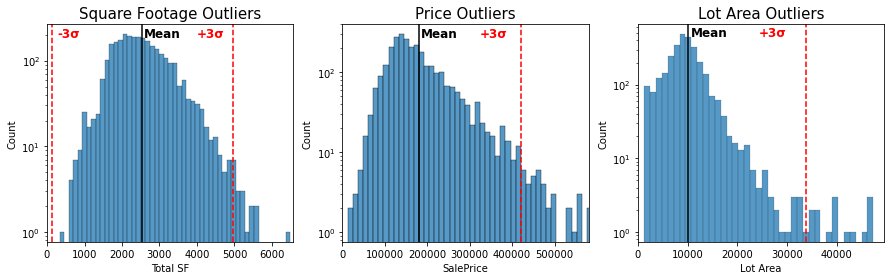

In [10]:
plt.subplots(1, 3, figsize = [15, 4])
plt.subplot(1, 3, 1)
sf_outliers = plot_outliers(data_transform['Total SF'], 'Square Footage Outliers', 3)

plt.subplot(1, 3, 2)
price_outliers = plot_outliers(data_transform['SalePrice'], 'Price Outliers', 3)
plt.subplot(1, 3, 3)
lot_area_outliers = plot_outliers(data_transform['Lot Area'], 'Lot Area Outliers', 3)
plt.show()

There are a number of houses that have either square footage, price, or lot area 3σ outside the mean. We can safely discard these listings as outliers.

In [11]:
# Combine individual outlier datasets
all_outliers = sf_outliers | price_outliers | lot_area_outliers
message = f'===== {sum(all_outliers)} outliers identified and removed ====='
print(f'{"=" * len(message)}\n{message}\n{"=" * len(message)}')

# Drop outliers
data_transform = data_transform.loc[~all_outliers, :]

===== 75 outliers identified and removed =====


---
## Identifying columns for use in the model

### plot_corrs

**Parameters**
* *corrs* = the dataframe containing all correlations in this dataset
* *cols_to_plot* = a list of the names of columns that are going to be plotted
* *comparison_col* = the name of the column against which the cols_to_plot will be correlated
* *chart_rows* = the number of individial rows to split the resulting plot into
* *chart_cols* = the number of indivicual columns to split the resulting plot into
* *fig_width* = the width of the final figure
* *fig_height* = the height of the final figure

**Returns**
* Produces and displays a heatmap

In [12]:
def plot_corrs(corrs, cols_to_plot, comparison_col, chart_rows, chart_cols, fig_width = 10, fig_height = 10):
    num_corrs = len(cols_to_plot)
    corrs_per_cell = int(np.round_(num_corrs/(chart_rows * chart_cols)))
    fig, ax = plt.subplots(chart_rows, chart_cols, figsize=(fig_width, fig_height))
    
    subplot_num = 1
    show_cbar = False
    # For each subplot
    for col in range(1, chart_cols + 1):
        for row in range(1, chart_rows + 1):
            start_index = (subplot_num - 1) * corrs_per_cell
            end_index = start_index + corrs_per_cell
            
            # Ensure we are not exceeding the bounds of our dataset
            if (end_index >= len(cols_to_plot)):
                end_index = len(cols_to_plot)
            elif (end_index + corrs_per_cell) > len(cols_to_plot) + 1:
                end_index = len(cols_to_plot)
            if (col == chart_cols) & (row == chart_rows):    
                show_cbar = True
                
            cell_cols = []
            for k in range(start_index, end_index):
                cell_cols.append(cols_to_plot[k])
            
            # Plot the appropriate correlation values in this subplot
            plt.subplot(chart_rows, chart_cols, subplot_num)
            sns.heatmap(pd.DataFrame(corrs.loc[cell_cols, comparison_col]), cmap = 'coolwarm', square = True,
                        vmin = -1, center = 0, vmax = 1, annot = True, cbar = show_cbar)
            subplot_num += 1
    plt.show()

### drop_cols
**Parameters**
* *df* - the DataFrame from which to drop columns
* *col_group* - a string describing the group of columns that are being dropped
* *current_cols* - a string array containing the names of columns that were analyzed
* *cols_to_keep* - a string array containing the names of columns that should be kept

**Returns**
* *df* - the updated DatFrame

In [13]:
def drop_cols(df, col_group, current_cols, cols_to_keep):
    # Keep requested columns
    cols_to_drop = current_cols
    for col in cols_to_keep:
        cols_to_drop.remove(col)
        
    # Drop columns
    df = df.drop(cols_to_drop, axis = 'columns')
    
    # Print out results
    message = f'===== {len(cols_to_drop)} {col_group} columns were removed from analysis ====='
    print(f'{len(message) * "="}\n{message}\n{len(message) * "="}\n')
    print(cols_to_drop)
    message = f'===== {df.shape[1]} columns remain ====='
    print(f'\n{len(message) * "="}\n{message}\n{len(message) * "="}')

    
    return df

With 202 columns, choosing which ones to use for our model is a major challenge. In addition to choosing columns that predict the SalePrice accurately, there are several common pitfalls we need to avoid:
1. [**Collinarity**](https://en.wikipedia.org/wiki/Multicollinearity#Consequences) - utilizing columns that are closely related to each other in a model (for example, Total square feet and 1st floor square feet)
2. **Overstratification** - this dataset contains many categorical columns. Over utilization of these columns could lead to creation of data subsets that do not have enough values to produce estimations with any statistical significance
3. [**Data Leakage**](https://machinelearningmastery.com/data-leakage-machine-learning/) - feature engineering can lead to incorporation of information that is not inherent to the dataset, thereby reducing the model's accuracy.

First, lets examine how each of the 202 columns in the dataset correlate with SalePrice.

In [14]:
correlations = data_transform.corr()

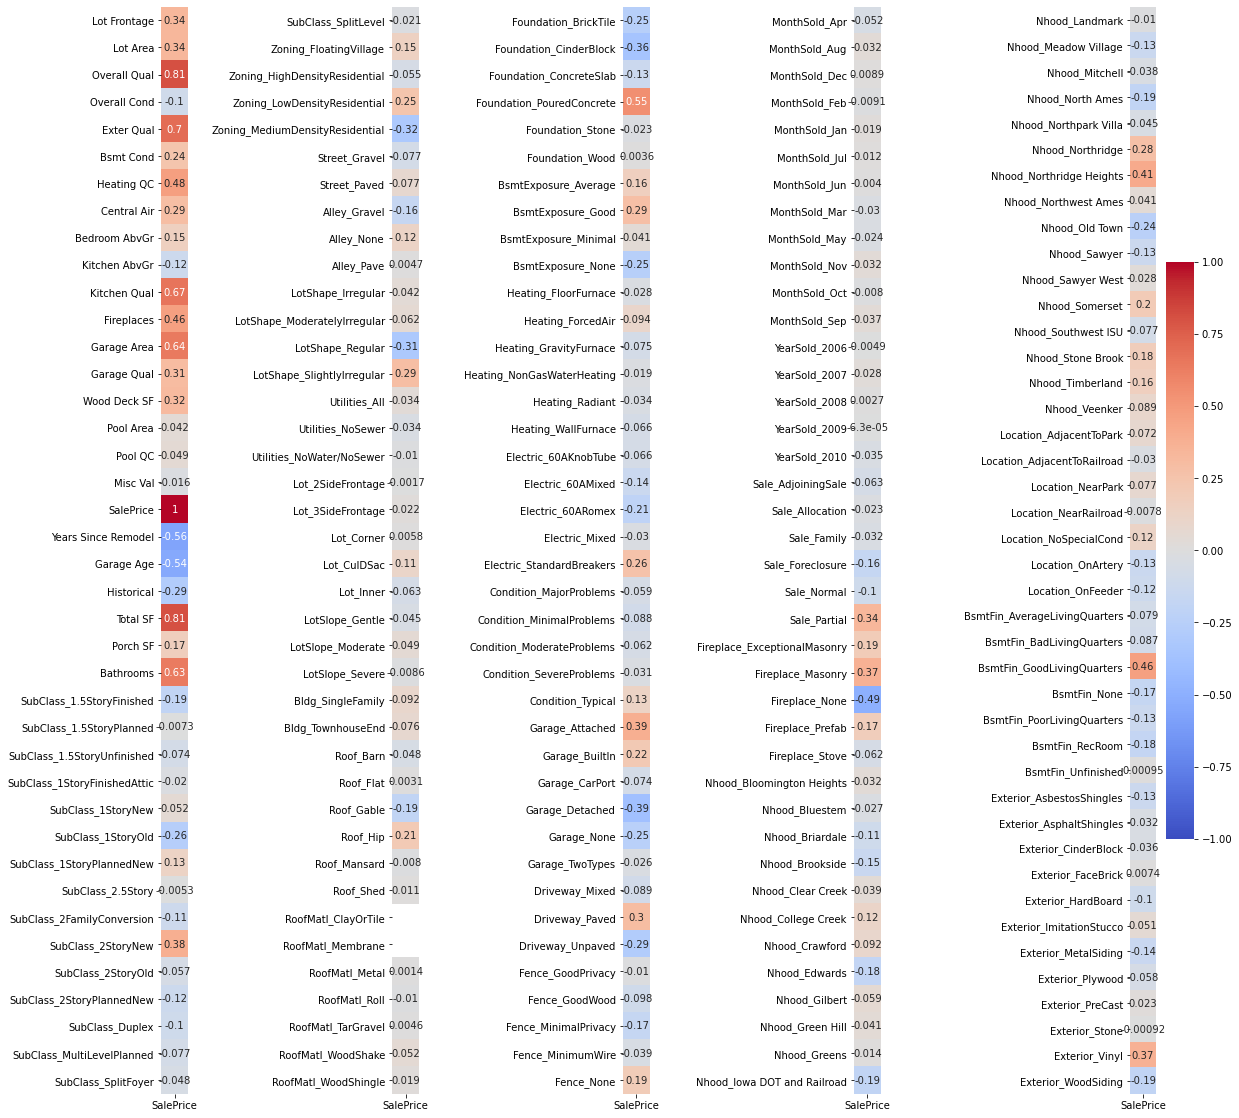

In [15]:
plot_corrs(correlations, correlations.columns.tolist(), 'SalePrice', 1, 5, 20, 20)

With 202 values, a single heatmap is impossible to interpret. Instead, lets break the correlations out into smaller groups.

### Vital Statistics
When looking for a house, there are several numbers that typically drive a purchase. These *"vital statistics"* include the number of **bedrooms**, number of **bathrooms**, and the **square footage** of the house.

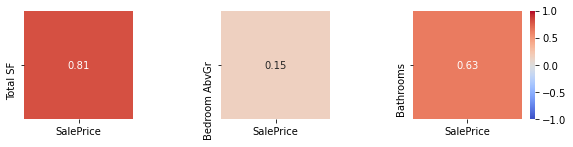

In [16]:
vital_cols = ['Total SF', 'Bedroom AbvGr', 'Bathrooms']
plot_corrs(correlations, vital_cols, 'SalePrice', 1, 3, 10, 2)

The strongest predictor of price amongst a home's vital statistics is the **total square footage** of the house. After that, the **number of bathrooms** (which is in part related to the total square footage) is the strongest indicator. 

All of these values are important factors in home price, but it is important to note that **number of bedrooms and number of bathrooms does correlate with SalePrice.** Despite this collinearity, I kept all three columns for use in the model

### Quality Metrics
The Ames, IA dataset provides us with several *"quality metrics"* which roll many different factors into one number.

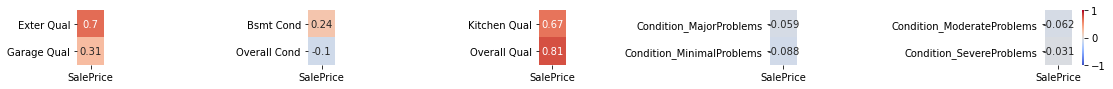

In [17]:
quality_metric_cols = ['Exter Qual', 'Garage Qual', 'Bsmt Cond', 
                       'Overall Cond', 'Kitchen Qual', 'Overall Qual']
functional_cols = data_transform.columns[data_transform.columns.str.contains('Condition')].tolist()
quality_metric_cols = quality_metric_cols + functional_cols
plot_corrs(correlations, quality_metric_cols, 'SalePrice', 1, 5, 20, 1)

**Kitchen quality**, **exterior quality**, and **Overall Quality** are strongly correlated with higher home prices. Surprisingly, the *"Functional"* condition of the house does not have a strong correlation with house price other than typical functionality predicts a higher price than any reduced functionality.

In [18]:
data_transform = drop_cols(data_transform, 'Quality Metrics', quality_metric_cols, ['Exter Qual', 'Kitchen Qual'])

===== 9 Quality Metrics columns were removed from analysis =====

['Garage Qual', 'Bsmt Cond', 'Overall Cond', 'Overall Qual', 'Condition_MajorProblems', 'Condition_MinimalProblems', 'Condition_ModerateProblems', 'Condition_SevereProblems', 'Condition_Typical']

===== 193 columns remain =====


### Neighborhood

Examining the correlation between neighborhood and sales price, we are confronted with two problems:
1. Insufficient datapoints in certain neighborhoods (Green Hill has 2 sales; Landmark, 1)
2. Potential collinearity between neighborhoods (Northridge/Northridge Heights)

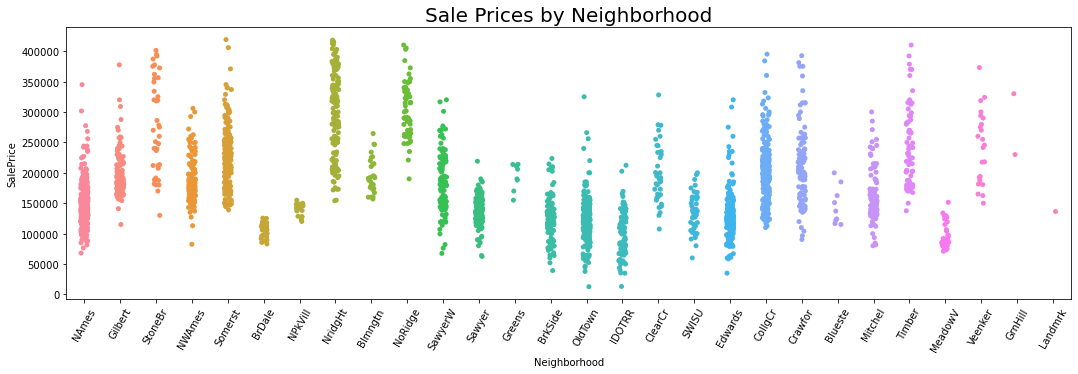

In [19]:
neighborhoods_original = data.loc[~all_outliers, ['Neighborhood', 'SalePrice']]
neighborhoods_map = transform_dictionary['Neighborhood']
plt.subplots(1, 1, figsize = [18, 5])
sns.stripplot(data = neighborhoods_original, x = 'Neighborhood', y = 'SalePrice')
x = plt.xticks(rotation = 60)
x = plt.title('Sale Prices by Neighborhood', size = 20)

Even with these problems, it does appear that there is a relationship between neighborhood and SalePrice. This is not surprising, since location can often drive real estate prices more strongly than house characteristics.

To circumvent the issues of insufficient data and collinearity, I grouped neighborhoods geographically, assuming that 'areas' of the city would have similar property values and desirabilities. Using a survey map of Ames, Iowa, I divided the 26 neighborhoods into 10 geographic groups as shown below:

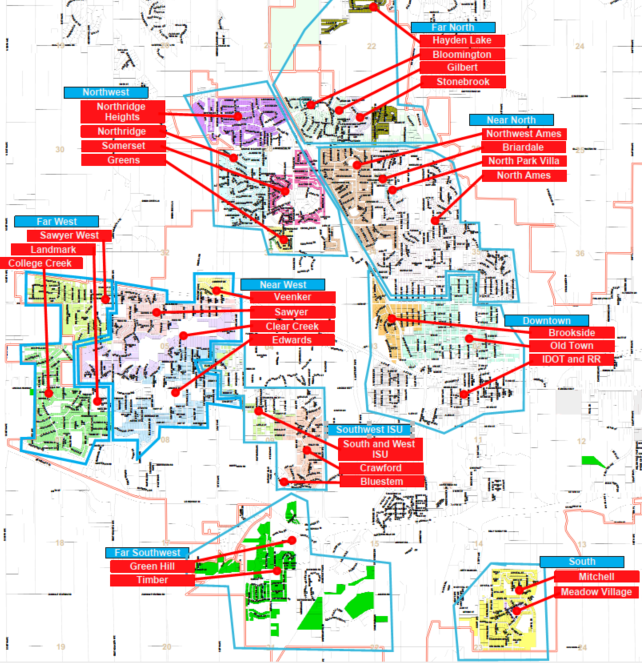

---
There are definite drawbacks to this method of separating the neighborhoods. In some locations, a single block can separate a dangerous part of town from an affluent area. For the purposes of this project, I felt it was a reasonable solution. Examining the strip plot below, we can see that each geographic grouping has a reasonable number of datapoints, while there is still a demonstrable relationship between SalePrice and the geographic group.

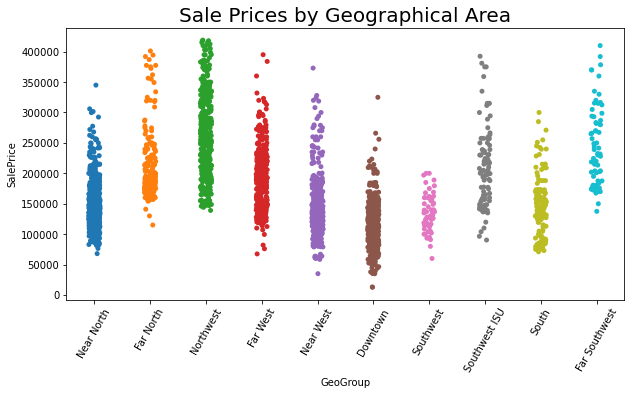

In [20]:
neighborhoods_grouped = neighborhoods_original.copy()

# Change neighborhood columns into geographic groups
neighborhoods_grouped['GeoGroup'] = neighborhoods_grouped['Neighborhood'].map(neighborhoods_map)
neighborhoods_grouped['GeoGroup'] = neighborhoods_grouped['GeoGroup'].map(neighborhood_grouping)

plt.subplots(1, 1, figsize = [10, 5])
sns.stripplot(data = neighborhoods_grouped, x = 'GeoGroup', y = 'SalePrice')
x = plt.xticks(rotation = 60)
x = plt.title('Sale Prices by Geographical Area', size = 20)

In [21]:
# Create new dummy columns
geogroup_dummies = pd.get_dummies(neighborhoods_grouped['GeoGroup'], prefix = 'GeoGroup')
neighborhoods_grouped = neighborhoods_grouped.drop(['GeoGroup', 'Neighborhood'], axis = 1)
neighborhoods_grouped = pd.concat([neighborhoods_grouped, geogroup_dummies], axis = 1)

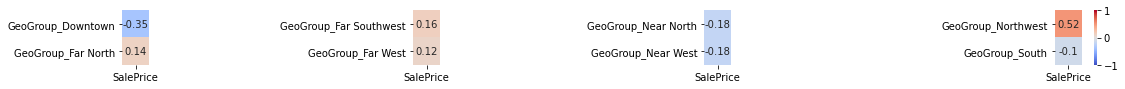

In [22]:
# Plot geogrouped correlations
geo_correlations = neighborhoods_grouped.corr()
geo_cols_to_plot = neighborhoods_grouped.columns[neighborhoods_grouped.columns.str.contains('GeoGroup')] 
plot_corrs(geo_correlations, geo_cols_to_plot, 'SalePrice', 1, 4, 20, 1)

This shows us that:
* Homes located in the **Northwest** neighborhoods are likely to have a *higher SalesPrice*
* Homes located in the **Downtown** neighborhoods are likely to have a *lower SalesPrice*.

In [23]:
# Remove individual neighborhood columns and add geogrouped columns to the dataset
neighborhood_cols = data_transform.columns[data_transform.columns.str.contains('Nhood')].tolist()
data_transform = drop_cols(data_transform, 'original neighborhood', neighborhood_cols, [])

data_transform = pd.concat([data_transform, geogroup_dummies], axis = 1)

===== 28 original neighborhood columns were removed from analysis =====

['Nhood_Bloomington Heights', 'Nhood_Bluestem', 'Nhood_Briardale', 'Nhood_Brookside', 'Nhood_Clear Creek', 'Nhood_College Creek', 'Nhood_Crawford', 'Nhood_Edwards', 'Nhood_Gilbert', 'Nhood_Green Hill', 'Nhood_Greens', 'Nhood_Iowa DOT and Railroad', 'Nhood_Landmark', 'Nhood_Meadow Village', 'Nhood_Mitchell', 'Nhood_North Ames', 'Nhood_Northpark Villa', 'Nhood_Northridge', 'Nhood_Northridge Heights', 'Nhood_Northwest Ames', 'Nhood_Old Town', 'Nhood_Sawyer', 'Nhood_Sawyer West', 'Nhood_Somerset', 'Nhood_Southwest ISU', 'Nhood_Stone Brook', 'Nhood_Timberland', 'Nhood_Veenker']

===== 165 columns remain =====


### Location within Neighborhood

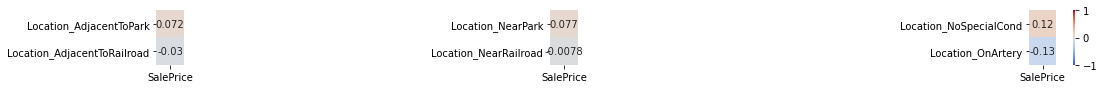

In [24]:
condition_cols = data_transform.columns[data_transform.columns.str.contains('Location')].tolist()
plot_corrs(correlations, condition_cols, 'SalePrice', 1, 3, 20, 1)

These columns relate to features near the sold property. Positive features, such as a **nearby park** are correlated with *increased SalePrice*. **Proximity to busy streets** (Artery, Feeder) are correlated with *decreased prices*.
These columns provide information within neighborhoods, so they are likely not colinear with neighborhood and should be kept in the analysis.

I was surprised to see that proximity to a railroad is not a major driver of price.

In [25]:
data_transform = drop_cols(data_transform, 'sub-neighborhood location', condition_cols, ['Location_NearPark', 'Location_OnArtery', 'Location_OnFeeder'])

===== 4 sub-neighborhood location columns were removed from analysis =====

['Location_AdjacentToPark', 'Location_AdjacentToRailroad', 'Location_NearRailroad', 'Location_NoSpecialCond']

===== 171 columns remain =====


### Utility Characteristics
The condition of the house's functional features, such as plumbing, electricity, and HVAC can drive home price. In Iowa, where summers are hot and winters are cold, houses with acceptable air conditioning likely demand a higher price than those without.

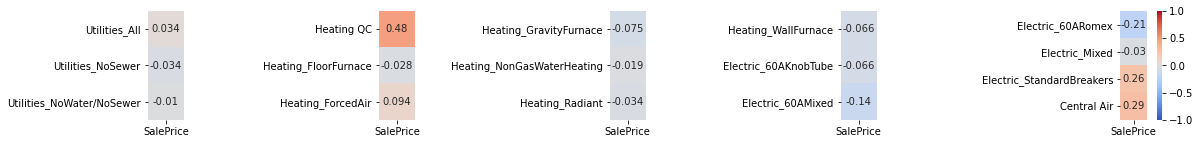

In [26]:
utility_cols = data_transform.columns[data_transform.columns.str.contains('Utilities')].tolist()\
                + data_transform.columns[data_transform.columns.str.contains('Heating')].tolist()\
                + data_transform.columns[data_transform.columns.str.contains('Electric')].tolist()\
                + ['Central Air']
plot_corrs(correlations, utility_cols, 'SalePrice', 1, 5, 20, 2)

This shows that the presence of **central air** (whole house air conditioning), **up-to-date wiring**, and **overall heating quality** are correlated with higher price.

Low quality wiring appears to drive SalePrice down, but we will omit this from analysis, since this column is colinear with other electrical columns. Overall these columns are likely correlated with house age.

In [27]:
data_transform = drop_cols(data_transform, 'utility related', utility_cols, ['Heating QC', 'Central Air', 'Electric_StandardBreakers'])

===== 13 utility related columns were removed from analysis =====

['Utilities_All', 'Utilities_NoSewer', 'Utilities_NoWater/NoSewer', 'Heating_FloorFurnace', 'Heating_ForcedAir', 'Heating_GravityFurnace', 'Heating_NonGasWaterHeating', 'Heating_Radiant', 'Heating_WallFurnace', 'Electric_60AKnobTube', 'Electric_60AMixed', 'Electric_60ARomex', 'Electric_Mixed']

===== 158 columns remain =====


### Construction

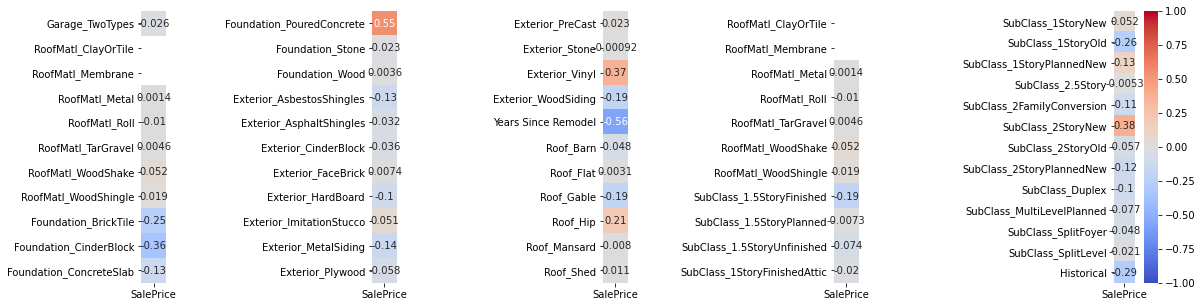

In [28]:
construct_cols = data_transform.columns[data_transform.columns.str.contains('Type')].tolist()\
                    + data_transform.columns[data_transform.columns.str.contains('RoofMatl')].tolist()\
                    + data_transform.columns[data_transform.columns.str.contains('Found')].tolist()\
                    + data_transform.columns[data_transform.columns.str.contains('Exterior')].tolist()\
                    + data_transform.columns[data_transform.columns.str.contains('Years')].tolist()\
                    + data_transform.columns[data_transform.columns.str.contains('Roof')].tolist()\
                    + data_transform.columns[data_transform.columns.str.contains('SubClass')].tolist()
construct_cols.append('Historical')
plot_corrs(correlations, construct_cols, 'SalePrice', 1, 5, 20, 5)

There appears to be insufficient information to make inferences on home price with respect to roofing material. However, there are *strong positive correlations* between **poured concrete foundation**/**vinyl siding** and SalePrice. This is **likely due to poured concrete foundations and vinyl exteriors being predominantly on new construction**. As a result, these columns are *likely colinear with years since renovation/construction*. I will omit these columns in favor of **years since remodel**.

To my surprise, the roof shape of a house does correlate with price. To avoid collinearity, I kept only the highest correlation roof type - hip - and removed the rest from analysis.

At the risk of introducing collinearity with Years Since Remodel, I chose to include SubClass_2StoryNew in the analysis, since the correlation between price and this type of construction is so strong.

In [29]:
data_transform = drop_cols(data_transform, 'construction related', construct_cols, ['Years Since Remodel', 'Roof_Hip', 'SubClass_2StoryNew'])

===== 54 construction related columns were removed from analysis =====

['Garage_TwoTypes', 'RoofMatl_ClayOrTile', 'RoofMatl_Membrane', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_TarGravel', 'RoofMatl_WoodShake', 'RoofMatl_WoodShingle', 'Foundation_BrickTile', 'Foundation_CinderBlock', 'Foundation_ConcreteSlab', 'Foundation_PouredConcrete', 'Foundation_Stone', 'Foundation_Wood', 'Exterior_AsbestosShingles', 'Exterior_AsphaltShingles', 'Exterior_CinderBlock', 'Exterior_FaceBrick', 'Exterior_HardBoard', 'Exterior_ImitationStucco', 'Exterior_MetalSiding', 'Exterior_Plywood', 'Exterior_PreCast', 'Exterior_Stone', 'Exterior_Vinyl', 'Exterior_WoodSiding', 'Roof_Barn', 'Roof_Flat', 'Roof_Gable', 'Roof_Mansard', 'Roof_Shed', 'RoofMatl_ClayOrTile', 'RoofMatl_Membrane', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_TarGravel', 'RoofMatl_WoodShake', 'RoofMatl_WoodShingle', 'SubClass_1.5StoryFinished', 'SubClass_1.5StoryPlanned', 'SubClass_1.5StoryUnfinished', 'SubClass_1StoryFinishedAttic', 'Sub

### Basement

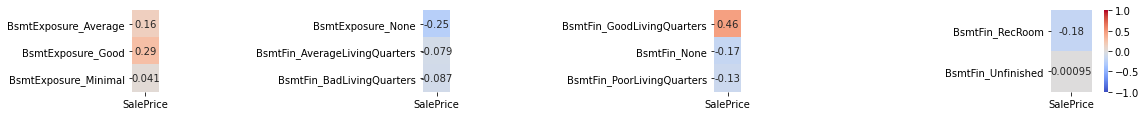

In [30]:
basement_cols = data_transform.columns[data_transform.columns.str.contains('Bsmt')].tolist()

plot_corrs(correlations, basement_cols, 'SalePrice', 1, 4, 20, 1.5)

The characteristics of the basement that correlate with price are the presence of **good living quarters** and the presence of a **basement walk-out**. The other columns in this set are colinear with these columns, so I dropped all but the two with the strong correlations.

In [31]:
data_transform = drop_cols(data_transform, 'basement related', basement_cols, ['BsmtExposure_Good', 'BsmtFin_GoodLivingQuarters'])

===== 9 basement related columns were removed from analysis =====

['BsmtExposure_Average', 'BsmtExposure_Minimal', 'BsmtExposure_None', 'BsmtFin_AverageLivingQuarters', 'BsmtFin_BadLivingQuarters', 'BsmtFin_None', 'BsmtFin_PoorLivingQuarters', 'BsmtFin_RecRoom', 'BsmtFin_Unfinished']

===== 102 columns remain =====


### Garage

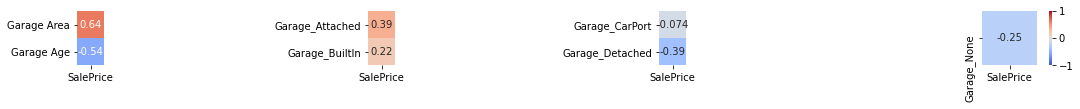

In [32]:
garage_cols = data_transform.columns[data_transform.columns.str.contains('Garage')].tolist()
plot_corrs(correlations, garage_cols, 'SalePrice', 1, 4, 20, 1)

Although there are strong correlations in this group, I believe that there are strong colinearities between many of thes columns and other columns that are vital to the analysis:
* Garage Area ~ Total SF
* Garage Age ~ Years since remodel

In this case, I think that the only column that is not colinear with other important columns is **Garage_Attached**.

In [33]:
data_transform = drop_cols(data_transform, 'garage related', garage_cols, ['Garage_Attached'])

===== 6 garage related columns were removed from analysis =====

['Garage Area', 'Garage Age', 'Garage_BuiltIn', 'Garage_CarPort', 'Garage_Detached', 'Garage_None']

===== 96 columns remain =====


### Lot Characteristics

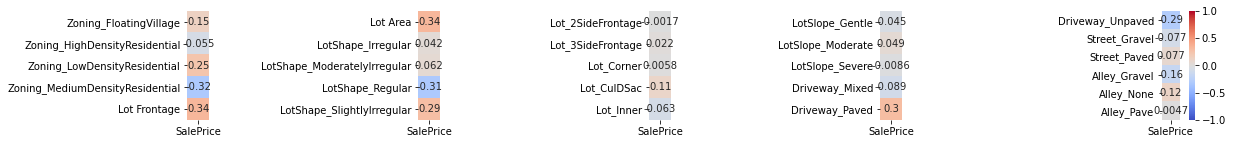

In [34]:
lot_cols = data_transform.columns[data_transform.columns.str.contains('Zoning')].tolist()\
             + data_transform.columns[data_transform.columns.str.contains('Lot')].tolist()\
             + data_transform.columns[data_transform.columns.str.contains('Drive')].tolist()\
             + data_transform.columns[data_transform.columns.str.contains('Street')].tolist()\
             + data_transform.columns[data_transform.columns.str.contains('Alley')].tolist()
plot_corrs(correlations, lot_cols, 'SalePrice', 1, 5, 20, 2)

There are strong correlations between several lot characteristics and SalePrice, but **lot characteristics are almost certainly strongly correlated with building age and neighborhood**. Because of this, I will omit several of these columns from analysis.

I will keep the metrics that relate to size of the lot, since this is not necessarily correlated with house size. I will also keep the presence of a cul-de-sac, since that is independent of lot size and neighborhood.

In [35]:
data_transform = drop_cols(data_transform, 'lot related', lot_cols, ['Lot Area', 'Lot_CulDSac'])

===== 24 lot related columns were removed from analysis =====

['Zoning_FloatingVillage', 'Zoning_HighDensityResidential', 'Zoning_LowDensityResidential', 'Zoning_MediumDensityResidential', 'Lot Frontage', 'LotShape_Irregular', 'LotShape_ModeratelyIrregular', 'LotShape_Regular', 'LotShape_SlightlyIrregular', 'Lot_2SideFrontage', 'Lot_3SideFrontage', 'Lot_Corner', 'Lot_Inner', 'LotSlope_Gentle', 'LotSlope_Moderate', 'LotSlope_Severe', 'Driveway_Mixed', 'Driveway_Paved', 'Driveway_Unpaved', 'Street_Gravel', 'Street_Paved', 'Alley_Gravel', 'Alley_None', 'Alley_Pave']

===== 72 columns remain =====


### Special Features

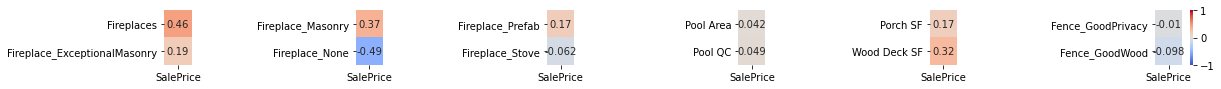

In [36]:
special_cols = data_transform.columns[data_transform.columns.str.contains('Fireplace')].tolist()\
                  + data_transform.columns[data_transform.columns.str.contains('Pool')].tolist()\
                  + data_transform.columns[data_transform.columns.str.contains('Porch')].tolist()\
                  + data_transform.columns[data_transform.columns.str.contains('Deck')].tolist()\
                  + data_transform.columns[data_transform.columns.str.contains('Fence')].tolist()
plot_corrs(correlations, special_cols, 'SalePrice', 1, 6, 20, 1)

It appears that the number of fireplaces, the type of fireplace, the square footage of a deck/porch, and the *absence* of a fence are positively correlated with SalePrice. Unfortunately, the number of fireplaces and deck/porch square footage are likely colinear with house square footage. To get around this collinearity, I decided to convert these columns into binary values - a house either has fireplaces or not. They either have a wood deck, or not. The same logic applied to fences. Although there are many specifiers for what type of fence exists, I decided to keep the most general metric: the presence or absence of a fence.

In [37]:
# Engineer columns that contain boolean metrics of special features
has_fireplace = pd.Series(data_transform['Fireplaces'] > 0, name = 'HasFireplace').astype(int)
has_deck = pd.Series(data_transform['Wood Deck SF'] > 0, name = 'HasDeck').astype(int)
has_porch = pd.Series(data_transform['Porch SF'] > 0, name = 'HasPorch').astype(int)
data_transform = pd.concat([data_transform, has_fireplace, has_deck, has_porch], axis = 1)

In [38]:
data_transform = drop_cols(data_transform, 'special feature related', special_cols, ['Fence_None'])

===== 14 special feature related columns were removed from analysis =====

['Fireplaces', 'Fireplace_ExceptionalMasonry', 'Fireplace_Masonry', 'Fireplace_None', 'Fireplace_Prefab', 'Fireplace_Stove', 'Pool Area', 'Pool QC', 'Porch SF', 'Wood Deck SF', 'Fence_GoodPrivacy', 'Fence_GoodWood', 'Fence_MinimalPrivacy', 'Fence_MinimumWire']

===== 61 columns remain =====


### Sale Conditions

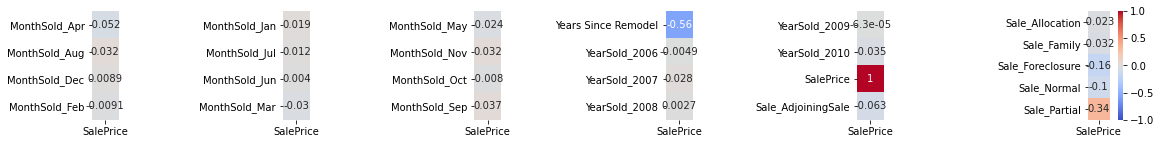

In [39]:
date_cols = data_transform.columns[data_transform.columns.str.contains('Month')].tolist()\
                + data_transform.columns[data_transform.columns.str.contains('Year')].tolist()\
                + data_transform.columns[data_transform.columns.str.contains('Sale')].tolist()
plot_corrs(correlations, date_cols, 'SalePrice', 1, 6, 20, 2)

There does not appear to be a significant correlation between the month or year in which a sale took place and the SalePrice.

There is a significant correlation between **Sale_Partial** and SalePrice, but I decided to exclude this column from analysis, since a partial sale STRONGLY correlates with Years Since Remodel (essentially, it means that the house was incomplete when it was last examined by the city).

I decided to keep the **Sale_Foreclosure** column, since foreclosed houses nearly always sell at a heavy discount and that should be reflected in the model.

In [40]:
data_transform = drop_cols(data_transform, 'sale date related', date_cols, ['Years Since Remodel', 'Sale_Foreclosure', 'SalePrice'])

===== 22 sale date related columns were removed from analysis =====

['MonthSold_Apr', 'MonthSold_Aug', 'MonthSold_Dec', 'MonthSold_Feb', 'MonthSold_Jan', 'MonthSold_Jul', 'MonthSold_Jun', 'MonthSold_Mar', 'MonthSold_May', 'MonthSold_Nov', 'MonthSold_Oct', 'MonthSold_Sep', 'YearSold_2006', 'YearSold_2007', 'YearSold_2008', 'YearSold_2009', 'YearSold_2010', 'Sale_AdjoiningSale', 'Sale_Allocation', 'Sale_Family', 'Sale_Normal', 'Sale_Partial']

===== 39 columns remain =====


## Misc Remaining Metrics

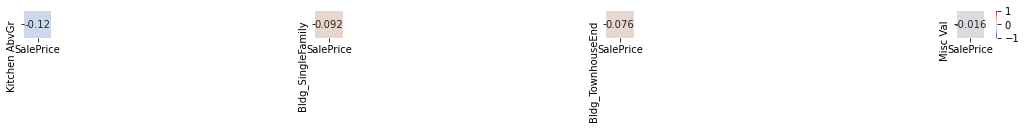

In [41]:
remaining_cols = ['Kitchen AbvGr', 'Bldg_SingleFamily', 'Bldg_TownhouseEnd', 'Misc Val']
plot_corrs(correlations, remaining_cols, 'SalePrice', 1, 4, 20, 0.5)

In [42]:
data_transform = drop_cols(data_transform, 'misc columns', remaining_cols, [])

===== 4 misc columns columns were removed from analysis =====

['Kitchen AbvGr', 'Bldg_SingleFamily', 'Bldg_TownhouseEnd', 'Misc Val']

===== 35 columns remain =====


### Summary
Based on the analyses performed above, we are left with relatively few columns that provide useful, unique information.

| **Category** | | | | | |
|------------------------------:|:----------------------:|:--------------------------:|:-----------------:|:-------------------:|--:|
|          **Vital Statistics** |        Total SF        |          Bathrooms         |      Bedrooms     | Years Since Remodel |   |
|           **Quality Metrics** |       Exter Qual       |        Kitchen Qual        |                   |                     |   |
|              **Neighborhood** | All geographic columns |                            |                   |                     |   |
| **Sub-neighborhood Location** |    Location_NearPark   |      Location_OnArtery     | Location_OnFeeder |                     |   |
|                 **Utilities** |       Heating QC       |  Electric_StandardBreakers |    Central Air    |                     |   |
|              **Construction** |        Hip Roof        |       Historical Home      |                   |                     |   |
|                  **Basement** |    BsmtExposure_Good   | BsmtFin_GoodLivingQuarters |                   |                     |   |
|                    **Garage** |     Garage_Attached    |                            |                   |                     |   |
|                       **Lot** |        Lot Area        |         Lot_CulDSac        |                   |                     |   |
|          **Special Features** |        Fireplace       |            Deck            |       Porch       |        Fence        |   |

---
## Model Predictions

With a set of relatively non-colinear columns in hand to perform fitting on, I moved forward with creating both K Nearest Neighbors and Linear Regression fits of the data.

### Creating Data Subsets

In [43]:
fit_cols = data_transform.columns.tolist()
fit_cols.remove('SalePrice')
message = f'===== Final columns used in machine learning analysis ====='
print(f'{"=" * len(message)}\n{message}\n{"=" * len(message)}')
print(fit_cols)

===== Final columns used in machine learning analysis =====
['Lot Area', 'Exter Qual', 'Heating QC', 'Central Air', 'Bedroom AbvGr', 'Kitchen Qual', 'Years Since Remodel', 'Total SF', 'Bathrooms', 'SubClass_2StoryNew', 'Lot_CulDSac', 'Roof_Hip', 'BsmtExposure_Good', 'Electric_StandardBreakers', 'Garage_Attached', 'Fence_None', 'Sale_Foreclosure', 'Location_NearPark', 'Location_OnArtery', 'Location_OnFeeder', 'BsmtFin_GoodLivingQuarters', 'GeoGroup_Downtown', 'GeoGroup_Far North', 'GeoGroup_Far Southwest', 'GeoGroup_Far West', 'GeoGroup_Near North', 'GeoGroup_Near West', 'GeoGroup_Northwest', 'GeoGroup_South', 'GeoGroup_Southwest', 'GeoGroup_Southwest ISU', 'HasFireplace', 'HasDeck', 'HasPorch']


In [44]:
vitals_only = ['Total SF', 'Bedroom AbvGr', 'Bathrooms']
quality_metrics = ['Exter Qual', 'Kitchen Qual']

no_geo = pd.Series(fit_cols)[~pd.Series(fit_cols).str.contains('Geo')].tolist()
only_geo = pd.Series(fit_cols)[pd.Series(fit_cols).str.contains('Geo')].tolist()

construction_only = ['Exter Qual', 'Heating QC', 'Central Air', 'Bedroom AbvGr', 'Kitchen Qual', 
                     'Years Since Remodel', 'Total SF', 'Bathrooms', 'SubClass_2StoryNew', 'Roof_Hip', 
                     'BsmtExposure_Good', 'Electric_StandardBreakers', 'Garage_Attached', 'Fence_None',
                     'BsmtFin_GoodLivingQuarters', 'HasFireplace', 'HasDeck', 'HasPorch']
no_special = fit_cols.copy()
no_special.remove('HasFireplace')
no_special.remove('HasDeck')
no_special.remove('HasPorch')

construction_only_no_special = construction_only.copy()
construction_only_no_special.remove('HasFireplace')
construction_only_no_special.remove('HasDeck')
construction_only_no_special.remove('HasPorch')

In [45]:
knn_fits = pd.DataFrame(columns = ['RMSE', 'StDev'])
lr_fits = pd.DataFrame(columns = ['RMSE', 'StDev'])

In [46]:
half_point = int(data_transform.shape[0]/2)

train_df = data_transform.iloc[:half_point, :]
test_df = data_transform.iloc[half_point:, :]

### K Nearest Neighbors

In [47]:
knn_fits.loc['All',:] = train_and_test_kneighbors(train_df, test_df, fit_cols, 'SalePrice', 10, 3)
knn_fits.loc['No Geo',:] = train_and_test_kneighbors(train_df, test_df, no_geo, 'SalePrice', 10, 3)
knn_fits.loc['Only Geo',:] = train_and_test_kneighbors(train_df, test_df, only_geo, 'SalePrice', 10, 3)
knn_fits.loc['Vitals Only',:] = train_and_test_kneighbors(train_df, test_df, vitals_only, 'SalePrice', 10, 3)
knn_fits.loc['Quality Metrics',:] = train_and_test_kneighbors(train_df, test_df, quality_metrics, 'SalePrice', 10, 3)
knn_fits.loc['Construction Only', :] = train_and_test_kneighbors(train_df, test_df, construction_only, 'SalePrice', 10, 3)
knn_fits.loc['No Special', :] = train_and_test_kneighbors(train_df, test_df, no_special, 'SalePrice', 10, 3)
knn_fits.loc['Construction No Special', :] = train_and_test_kneighbors(train_df, test_df, no_special, 'SalePrice', 10, 3)
knn_fits = knn_fits.reset_index()

### Linear Regression

In [48]:
lr_fits.loc['All', :] = train_and_test_linear_regression(train_df, test_df, fit_cols, 'SalePrice', 3)
lr_fits.loc['No Geo',:] = train_and_test_linear_regression(train_df, test_df, no_geo, 'SalePrice', 3)
lr_fits.loc['Only Geo',:] = train_and_test_linear_regression(train_df, test_df, only_geo, 'SalePrice', 3)
lr_fits.loc['Vitals Only',:] = train_and_test_linear_regression(train_df, test_df, vitals_only, 'SalePrice', 3)
lr_fits.loc['Quality Metrics',:] = train_and_test_linear_regression(train_df, test_df, quality_metrics, 'SalePrice', 3)
lr_fits.loc['Construction Only', :] = train_and_test_linear_regression(train_df, test_df, construction_only, 'SalePrice', 3)
lr_fits.loc['No Special', :] = train_and_test_kneighbors(train_df, test_df, no_special, 'SalePrice', 3)
lr_fits.loc['Construction No Special', :] = train_and_test_kneighbors(train_df, test_df, no_special, 'SalePrice', 3)
lr_fits = lr_fits.reset_index()

### Comparison

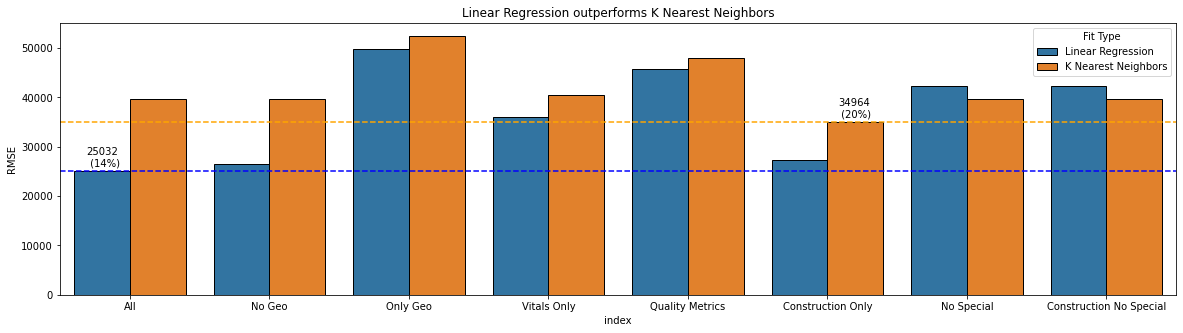

In [49]:
lr_fits['Fit Type'] = 'Linear Regression'
knn_fits['Fit Type'] = 'K Nearest Neighbors'
all_fits = pd.concat([lr_fits, knn_fits], axis = 0)
plt.subplots(1, 1, figsize = [20,5])
ax = sns.barplot(data = all_fits, x = 'index', y = 'RMSE', hue = 'Fit Type', edgecolor = 'black')
ax.set_title('Linear Regression outperforms K Nearest Neighbors')

min_lr = lr_fits['RMSE'].min()
min_knn = knn_fits['RMSE'].min()
ax.axhline(min_lr, color = 'blue', linestyle = '--')
ax.axhline(min_knn, color = 'orange', linestyle = '--')

txt = ax.text(x = -0.31, y = 26000, s = str(int(lr_fits['RMSE'].min())) + '\n (14%)')
txt = ax.text(x = 5.08, y = 36000, s = str(int(knn_fits['RMSE'].min())) + '\n (20%)')

## Conclusion

In this project, I worked with the Ames, Iowa housing dataset with the goal of predicting home prices based upon the many data columns within the dataset. Using a combination of data cleaning and feature engineering, I produced a dataset with information usable by a machine learning model. Afterwards, I examined individual columns in the dataset to determine which columns would be non-collinear and a good fit for use in the machine learning model. I performed K nearest neighbor and linear regression fitting of the dataset using different sets of columns. Based on this analysis, I identified that the lowest RMSE was provided by a linear regression model of all my selected columns. Generally, excluding more columns led to higher RMSEs, although this trend was not consistent in the k nearest neighghbor models, where the lowest RMSE was attributed to a model that only considered construction variables. The reason for this discrepancy is unclear to me.

In the end, the linear regression model using all my selected data columns obtained the best RMSE, \\$25,032, or 14% on an average sale price of \\$175,778. 